<a href="https://colab.research.google.com/github/chrisJ1252/tensorflow-1-public/blob/main/StudentPerformancePrediction(Regression)(NOTREALDATA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import zipfile

In [ ]:
fileToUnzip = '/content/drive/MyDrive/StudentPerformancePredictionData.zip'
zip_ref = zipfile.ZipFile(fileToUnzip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
data = pd.read_csv('student_performance.csv')
data.head()


,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85


In [ ]:
data.drop(["StudentID", "Name", "Gender", 'ParentalSupport'], axis = 1, inplace = True)

In [ ]:
data.head()

,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,FinalGrade
0,85,15,78,1,80
1,90,20,85,2,87
2,78,10,65,0,68
3,92,25,90,3,92
4,88,18,82,2,85


In [ ]:
data.isnull().sum()

,0
AttendanceRate,0
StudyHoursPerWeek,0
PreviousGrade,0
ExtracurricularActivities,0
FinalGrade,0


In [ ]:
negativeValuesStudyHrs = (data['StudyHoursPerWeek'] < 0).sum()
negativeValuesPreviousGrade = (data['PreviousGrade'] < 0).sum()
negativeValuesAttendanceRate = (data['AttendanceRate'] < 0).sum()
negativeValuesFinalGrade = (data['FinalGrade'] < 0).sum()
negativeValuesExtracurricularActivities = (data['ExtracurricularActivities'] < 0).sum()
print(negativeValuesExtracurricularActivities)
print(negativeValuesFinalGrade)
print(negativeValuesAttendanceRate)
print(negativeValuesPreviousGrade)
print(negativeValuesStudyHrs)

0
0
0
0
0


In [ ]:
features=[ 'AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade', 'ExtracurricularActivities']
X = data[features]
y = data['FinalGrade']


In [ ]:
features_num = ['AttendanceRate', 'StudyHoursPerWeek', 'PreviousGrade', 'ExtracurricularActivities']

In [ ]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
      ('num', numerical_pipeline, features_num),
    ],
    remainder='passthrough'
)
preprocessor.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['AttendanceRate', 'StudyHoursPerWeek',
                                  'PreviousGrade',
                                  'ExtracurricularActivities'])])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                                random_state=0) # splitting data

X_train = preprocessor.fit_transform(X_train) # fit transform, calculates standard dev for StandaardSCaler
X_valid = preprocessor.transform(X_valid) # applies transformations to data
y_train = y_train / 100
y_valid = y_valid / 100

In [ ]:
rf_model = RandomForestRegressor(random_state=0)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Assuming you have trained your model and have predictions for your validation set:
y_pred = best_rf_model.predict(X_valid)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_valid, y_pred)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_valid, y_pred, squared=False) # squared=False for RMSE
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_valid, y_pred)
print(f"Mean Absolute Error: {mae}")

# R-squared (R2)
r2 = r2_score(y_valid, y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 0.0015160933333333276
Root Mean Squared Error: 0.038937043202242866
Mean Absolute Error: 0.02953333333333315
R-squared: 0.7121341772151908


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape = [X_train.shape[1]]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    optimizer  = 'adam',
    loss = 'mae',
    metrics = ['mae']
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=1,
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1347 - mae: 0.1347 - val_loss: 0.4400 - val_mae: 0.4400
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5581 - mae: 1.5581 - val_loss: 0.4872 - val_mae: 0.4872
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3924 - mae: 1.3924 - val_loss: 0.3632 - val_mae: 0.3632
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.8916 - mae: 0.8916 - val_loss: 0.1765 - val_mae: 0.1765
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3550 - mae: 0.3550 - val_loss: 0.0955 - val_mae: 0.0955
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5302 - mae: 0.5302 - val_loss: 0.2331 - val_mae: 0.2331
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.6334 - mae: 0.6334 - val_loss: 0.2537 - val_mae: 0.2537
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.5216 - mae: 0.5216 - val_loss: 0.1863 - val_mae: 0.1863
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4197 - mae: 0.

Minimum Validation Loss: 0.0955


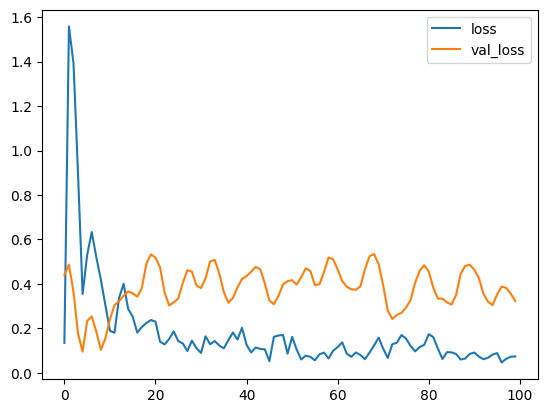

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [ ]:
def predict_model(model, X_input):
  """
  Predicts the target variable using the given model and input data.

  Args:
    model: The trained model (either RFR or NN).
    X_input: The input data for prediction.

  Returns:
    predictions: The predicted values.
  """

  # Apply preprocessing if the model is RFR
  if isinstance(model, Pipeline):  # Check if it's an RFR Pipeline
    predictions = model.predict(X_input)  # Directly predict on manual_data
  elif isinstance(model, tf.keras.Model): # Check if it's a NN model
    X_input = pd.DataFrame(X_input, columns=features)  # Convert to DataFrame
    X_input_transformed = preprocessor.transform(X_input)  # Preprocess for NN
    predictions = model.predict(X_input_transformed)
  # Check if the model is an instance of RandomForestRegressor
  elif isinstance(model, RandomForestRegressor):
    predictions = model.predict(X_input)  # Directly predict on manual_data
  else:
    raise ValueError("Unsupported model type")

  return predictions * 100  # Scale predictions back to original range

In [ ]:
def manual_input_data():
    """Manually collects data from the user and returns a DataFrame."""

    features = ['AttendanceRate', 'StudyHours', 'PreviousScore', 'ExtracurricularActivities']
    data = []

    num_samples = int(input("Enter the number of data points you want to input: "))

    for i in range(num_samples):
        sample_data = []
        print(f"Enter data for sample {i + 1}:")
        for feature in features:
            value = float(input(f"Enter {feature}: "))
            sample_data.append(value)
        data.append(sample_data)

    df = pd.DataFrame(data, columns=features)
    return df

# Get manually inputted data
manual_data = manual_input_data()

Enter the number of data points you want to input: 1
Enter data for sample 1:
Enter AttendanceRate: 90
Enter StudyHours: 27
Enter PreviousScore: 86
Enter ExtracurricularActivities: 1


In [ ]:
rfr_predictions = predict_model(best_rf_model, manual_data)
nn_predictions = predict_model(model, manual_data)

print("RFR Predictions:", rfr_predictions)
print("NN Predictions:", nn_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RFR Predictions: [90.27]
NN Predictions: [[128.23697]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
